# Advanced Quadrature Implementations

In [1]:
import math
from importlib import reload

import matplotlib.pyplot as plt
import pickle
import numpy as np

from tqdm.notebook import tqdm

from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time.environments import cartpole2
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

from pprint import pprint

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
cartpole2 = reload(cartpole2)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)

/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment CartPole-OURS-v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


## Prepare some data to test on

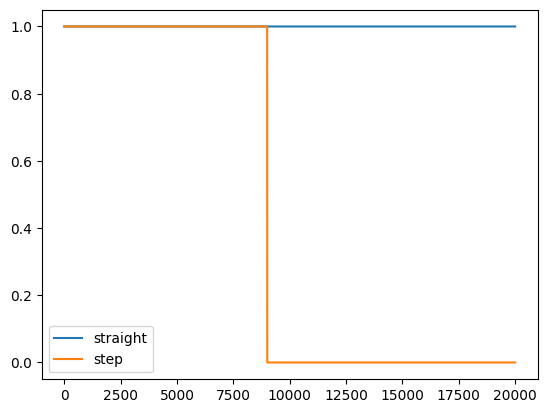

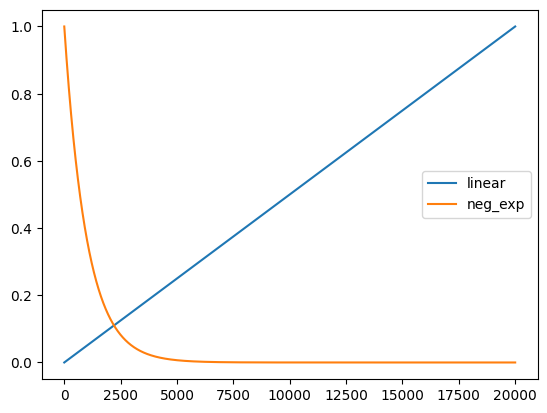

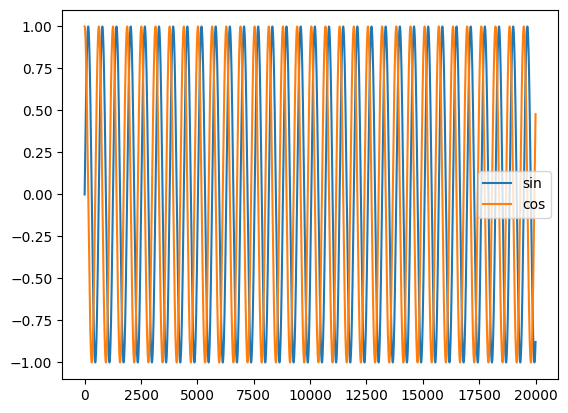

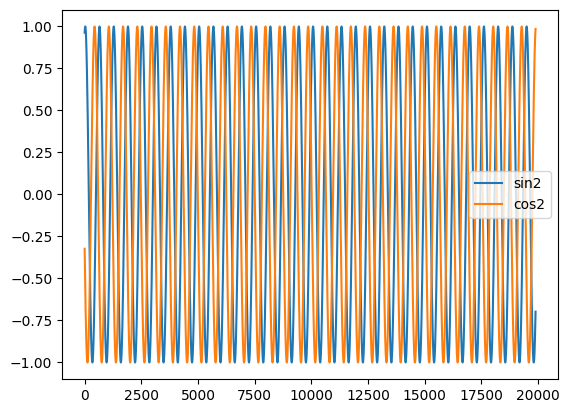

In [14]:
seed = 42

value_est.reset_randomness(seed, env=None)

data = {
    "straight": np.array([1] * 20_000),
    "step": np.array([1] * 9_000 + [0] * 11_000),
    "linear": np.arange(0, 20_000, 1) * 0.0001 / 2,
    "neg_exp": np.exp(-np.arange(0, 20, 0.001)),
    "sin": np.sin(np.arange(0, 200, 0.01)),
    "cos": np.cos(np.arange(0, 200, 0.01)),
    "sin2": np.sin(np.arange(1.3, 200.3, 0.01)),
    "cos2": np.cos(np.arange(1.9, 200.9, 0.01)),
}

for idx, (k, v) in enumerate(data.items()):
    if idx % 2 == 0:
        plt.figure()
    plt.plot(v, label=k)
    plt.legend()

In [16]:
true_integrals = {k: np.sum(v) for k, v in data.items()}
pprint(true_integrals)

{'cos': -87.07259580994176,
 'cos2': -111.40649854276533,
 'linear': 9999.5,
 'neg_exp': 1000.5000812711476,
 'sin': 51.717453803589905,
 'sin2': -44.77331462678737,
 'step': 9000,
 'straight': 20000}


In [17]:
unif_sampler_params = np.power(2, np.arange(0, 11, 2))
quad_sampler_params = np.concatenate(
    (np.array([0]), np.power(2, np.arange(-3.0, 12, 2))), axis=0
)

print('unif_sampler_params:', unif_sampler_params)
print('quad_sampler_params:', quad_sampler_params)

samplers_tried = {
    f'q{p}': approx_integrators.AdaptiveQuadratureIntegrator(tolerance=p)
    for p in quad_sampler_params
}
samplers_tried.update({
    f'u{p}': approx_integrators.UniformlySpacedIntegrator(p)
    for p in unif_sampler_params
})


unif_sampler_params: [   1    4   16   64  256 1024]
quad_sampler_params: [0.000e+00 1.250e-01 5.000e-01 2.000e+00 8.000e+00 3.200e+01 1.280e+02
 5.120e+02 2.048e+03]


In [20]:
approx_integrals = {}
num_pivots = {}

for sampler_name, sampler in tqdm(samplers_tried.items()):
    print("sampler_name:", sampler_name)
    approx_integrals[sampler_name] = []
    num_pivots[sampler_name] = []
    for label, value_seq in data.items():
        integral, all_pivots = sampler.integrate(value_seq)
        approx_integrals[sampler_name].append(integral)
        num_pivots[sampler_name].append(len(all_pivots))
    approx_integrals[sampler_name] = np.array(approx_integrals[sampler_name])
    num_pivots[sampler_name] = np.array(num_pivots[sampler_name])


  0%|          | 0/15 [00:00<?, ?it/s]

sampler_name: q0.0
sampler_name: q0.125
sampler_name: q0.5
sampler_name: q2.0
sampler_name: q8.0
sampler_name: q32.0
sampler_name: q128.0
sampler_name: q512.0
sampler_name: q2048.0
sampler_name: u1
sampler_name: u4
sampler_name: u16
sampler_name: u64
sampler_name: u256
sampler_name: u1024
{'q0.0': array([20000.        ,  9000.        ,  9999.5       ,  1000.50008127,
          51.7174538 ,   -87.07259581,   -44.77331463,  -111.40649854]),
 'q0.125': array([20000.        ,  9000.        ,  9999.5       ,  1000.51708298,
          51.71751956,   -87.07182118,   -44.77334711,  -111.40649845]),
 'q0.5': array([ 2.00000000e+04,  9.00000000e+03,  9.99950000e+03,  1.00061074e+03,
        1.00354396e+01, -8.70722274e+01, -4.47732621e+01,  1.01583486e+03]),
 'q128.0': array([20000.        ,  9000.        ,  9999.5       ,  1009.28976589,
       -9638.13035071, 16412.46016841,  4425.11739833, 10630.79666162]),
 'q2.0': array([ 2.00000000e+04,  9.00000000e+03,  9.99950000e+03,  1.00076065e+03,
  

In [22]:

pprint(num_pivots)


{'q0.0': array([    3,    29,     3, 20000, 20000, 20000, 19900, 19900]),
 'q0.125': array([    3,    29,     3,   567, 19475, 19446, 19405, 19399]),
 'q0.5': array([    3,    29,     3,   283, 16782, 17901, 17890, 15645]),
 'q128.0': array([ 3, 29,  3, 21,  7,  9, 15, 13]),
 'q2.0': array([    3,    29,     3,   143,  7235, 11609, 10121, 10095]),
 'q2048.0': array([ 3, 29,  3, 11,  3,  3,  3,  5]),
 'q32.0': array([  3,  29,   3,  35,  15, 199, 561, 217]),
 'q512.0': array([ 3, 29,  3, 13,  5,  5,  7,  7]),
 'q8.0': array([   3,   29,    3,   75,   25,  405, 4407, 2975]),
 'u1': array([20000, 20000, 20000, 20000, 20000, 20000, 19900, 19900]),
 'u1024': array([21, 21, 21, 21, 21, 21, 21, 21]),
 'u16': array([1251, 1251, 1251, 1251, 1251, 1251, 1245, 1245]),
 'u256': array([80, 80, 80, 80, 80, 80, 79, 79]),
 'u4': array([5001, 5001, 5001, 5001, 5001, 5001, 4976, 4976]),
 'u64': array([314, 314, 314, 314, 314, 314, 312, 312])}


In [23]:
pprint(approx_integrals)


{'q0.0': array([20000.        ,  9000.        ,  9999.5       ,  1000.50008127,
          51.7174538 ,   -87.07259581,   -44.77331463,  -111.40649854]),
 'q0.125': array([20000.        ,  9000.        ,  9999.5       ,  1000.51708298,
          51.71751956,   -87.07182118,   -44.77334711,  -111.40649845]),
 'q0.5': array([ 2.00000000e+04,  9.00000000e+03,  9.99950000e+03,  1.00061074e+03,
        1.00354396e+01, -8.70722274e+01, -4.47732621e+01,  1.01583486e+03]),
 'q128.0': array([20000.        ,  9000.        ,  9999.5       ,  1009.28976589,
       -9638.13035071, 16412.46016841,  4425.11739833, 10630.79666162]),
 'q2.0': array([ 2.00000000e+04,  9.00000000e+03,  9.99950000e+03,  1.00076065e+03,
       -1.42962423e+03, -8.70700289e+01, -3.94801072e+00,  1.01583972e+03]),
 'q2048.0': array([20000.        ,  9000.        ,  9999.5       ,  1042.99075947,
       -9454.0303696 , 16015.41000546,  3968.61539141, 10446.36750521]),
 'q32.0': array([20000.        ,  9000.        ,  9999.5   

### Plot the approximation qualities


/var/folders/xt/69nn93l959l31g_3b686nmsr0000gn/T/ipykernel_92313/3099497252.py:22: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")
/var/folders/xt/69nn93l959l31g_3b686nmsr0000gn/T/ipykernel_92313/3099497252.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 200_000)


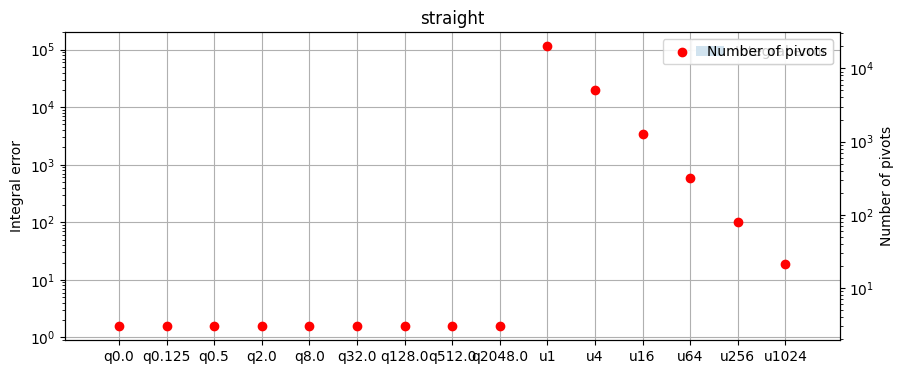

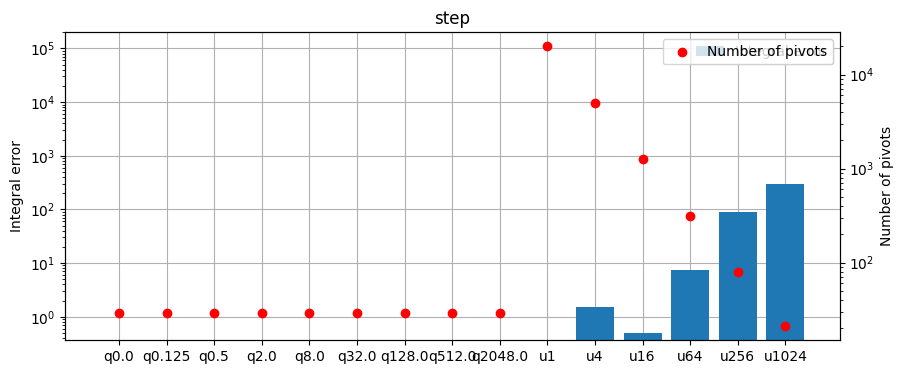

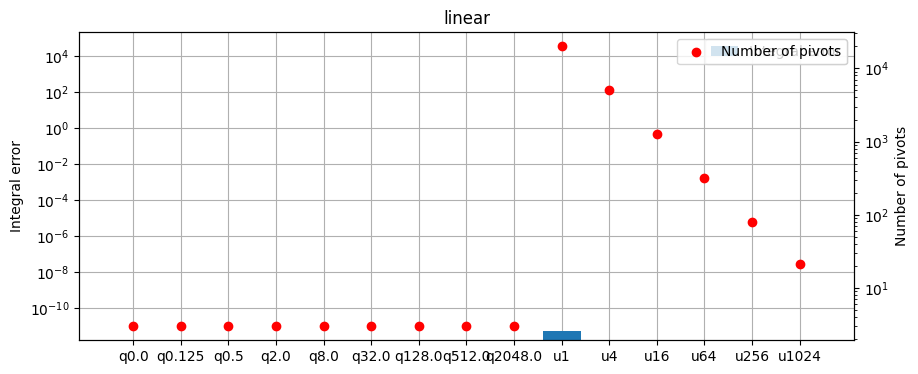

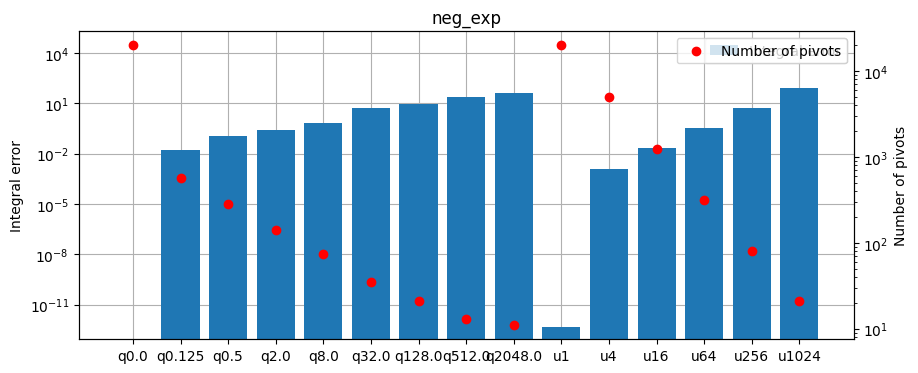

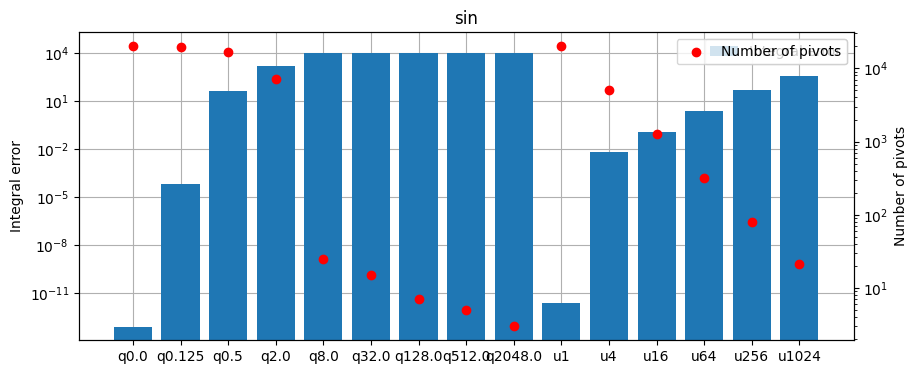

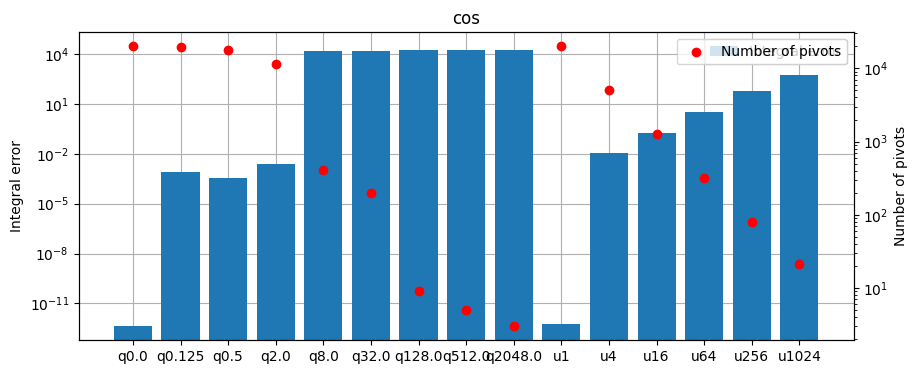

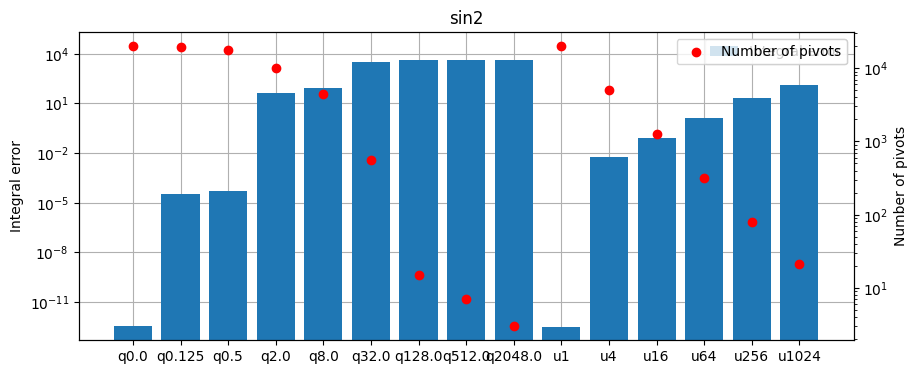

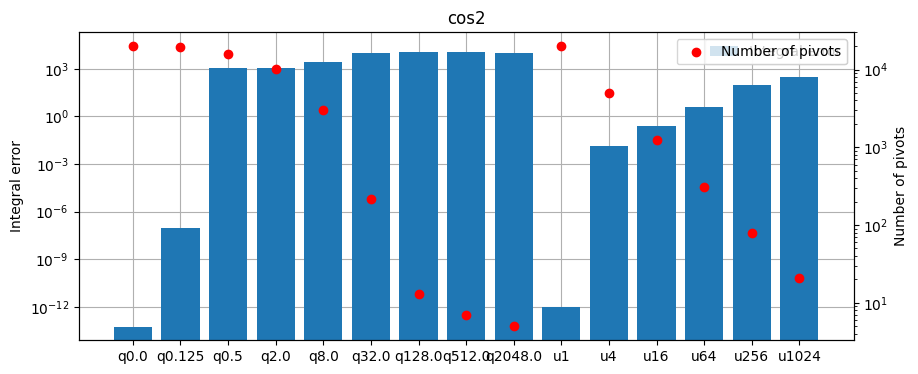

In [40]:
# Each data gets a different plot.
# -- on each plot, samplers go on the x-axes
# -- y-axes is the integral value error AND the number of pivots

for data_idx, data_name in enumerate(data.keys()):
    plt.figure(figsize=(10, 4))
    plt.title(data_name)
    ax = plt.gca()
    ax.grid()
    ax.set_axisbelow(True)
    ax2 = ax.twinx()
    method_names = []
    errs = []
    num_pivots_ = []
    for sampler_name, sampler in samplers_tried.items():
        method_names.append(sampler_name)
        errs.append(abs(true_integrals[data_name] - approx_integrals[sampler_name][data_idx]))
        num_pivots_.append(num_pivots[sampler_name][data_idx])
    ax.bar(method_names, errs, label="Integral error")
    ax2.scatter(method_names, num_pivots_, label="Number of pivots", color="red")
    # ax2.hlines(5, -1, len(method_names), color="gray", linestyle="--")
    ax.set_yscale("log")
    ax.set_ylim(0, 200_000)
    ax2.set_yscale("log")
    ax.set_ylabel("Integral error")
    ax2.set_ylabel("Number of pivots")
    # plt.yscale("log")
    # plt.legend()
    ax.legend(loc=0)
    ax2.legend()